In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

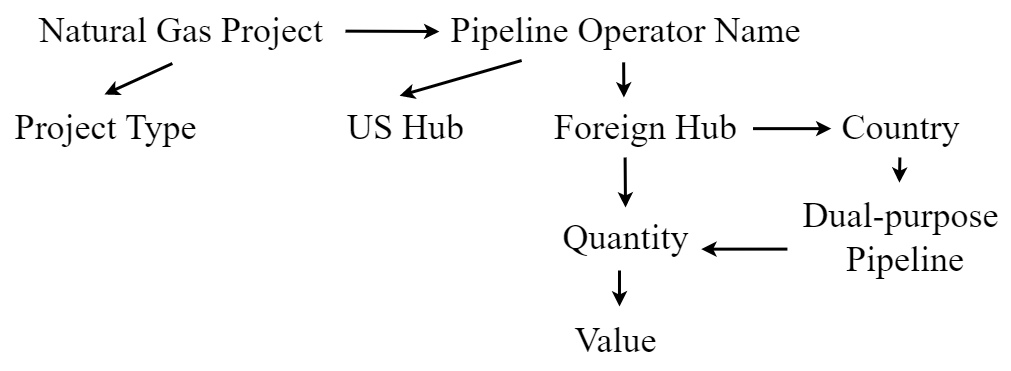

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Natural Gas Project, Value | Foreign Hub)?  Independent

CI (Natural Gas Project, Value | Pipeline Operator Name)?  Independent

CI (Foreign Hub, Dual-Purpose Pipeline | Country)? Independent

CI (Foreign Hub, Dual-Purpose Pipeline | County, Value)? Dependent

2) Now consider a smaller dataset with four discrete attributes (Pipeline Operator, US Hub, Foreign Hub, Quantity) as in as in HW3Q1_2.png, and the following conditional probability distributions:

Pipeline Operator: YHVA (70%), PLMG (30%)

Foreign Hub | Pipeline Operator Name = YHVA: Mexico Northeast Region (40%), Mexico Central Region (60%)

Foreign Hub | Pipeline Operator Name = PLMG: Mexico Northeast Region (100%)

US Hub | Pipeline Operator Name = PLMG: US Hub (100%)

US Hub | Pipeline Operator Name = YHVA: US Hub (100%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Northeast Region: Natural Gas (95%), Hydrogen (5%)

Quantity | Pipeline Operator Name = PLMG, Foreign Hub = Mexico Northeast Region: Natural Gas (98%), Hydrogen (2%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Central Region: Natural Gas (96%), Hydrogen (4%)

Which of the following cases is most anomalous?

a) Natural gas transported from the Mexico Northeast Region to a US Hub by PLMG

b) Natural gas transported from the Mexico Northeast Region to a US Hub by YHVA

c) Hydrogen trasported from the Mexico Central Region to a US Hub by YHVA

To answer this question, compute the likelihood of each fuel (natural gas and hydrogen) given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

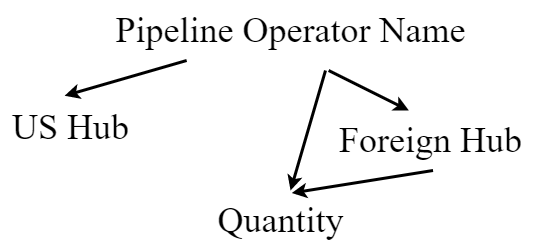

In [3]:
Image('HW3Q1_2.png')

Q = Quantity, Fh=Foreign Hub, Pon=Pipeline Operator Name, US=US Hub

P(Q=Natural Gas| Fh=North East, Pon=PLMG)*P(US=1|Pon=PLMG)*P(Pon=PLMG)
=0.98 * 1 * 1 * 0.3  = 29.4%

P(Q=NG|Fh=NE,Pon=YHVA)*P(Fh=NE|Pon=YHVA)*P(US=1|Pon=YHVA)*P(Pon=YHVA)
=0.95 * 0.4 * 1 * 0.7  = 26.6%

P(Q=HYDROGEN|Fh=CENTRAL,Pon=YHVA)*P(Fh=CENTRAL|Pon=YHVA)*P(US=1|Pon=YHVA)*P(Pon=YHVA)
=0.04 * 0.6 * 1 * 0.7 = 1.68%

The third case is the most anamolous where Hydrogen is transported via YHVA from Mexico central region to US hub.


### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [4]:
# You will need to install pgmpy
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,1,0
2,1,0,1,1,1,1
3,1,0,0,1,1,1
4,2,1,0,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [5]:
# your answers here
import pandas as pd
import numpy as np
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore

In [6]:
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
best_model_bayes = BayesianNetwork(best_model.edges())
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('C', 'A'), ('D', 'A'), ('F', 'A')]


In [7]:
best_model = BayesianNetwork([('C', 'A'), ('D', 'A'), ('F', 'A')])
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

CPD of C:
+------+--------+
| C(0) | 0.5015 |
+------+--------+
| C(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----+----------------------+
| C    | C(0)                 | ... | C(1)                 |
+------+----------------------+-----+----------------------+
| D    | D(0)                 | ... | D(1)                 |
+------+----------------------+-----+----------------------+
| F    | F(0)                 | ... | F(1)                 |
+------+----------------------+-----+----------------------+
| A(0) | 0.4965893587994543   | ... | 0.001349527665317139 |
+------+----------------------+-----+----------------------+
| A(1) | 0.5006821282401092   | ... | 0.5033738191632928   |
+------+----------------------+-----+----------------------+
| A(2) | 0.001364256480218281 | ... | 0.4939271255060729   |
+------+----------------------+-----+----------------------+
| A(3) | 0.001364256480218281 | ... | 0.001349527665317139 |
+------+----------------------+-----

In [8]:
test_x = test.loc[:,["C","D","F"]]
predicted_test = best_model.predict(test_x)
print("Out of sample:",(test.loc[:,'A'].reset_index(drop=True)==predicted_test['A']).mean())

  0%|          | 0/8 [00:00<?, ?it/s]

Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points+20 bonus points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (10 pts).

c) **(Bonus)** Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (10 pts)  

d) **(Bonus)** Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (10 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (10 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [9]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [10]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


In [11]:
column_headers = list(data3.columns.values)
print("The Column Header :", column_headers)

The Column Header : ['crime_type', 'Category', 'day_Sun', 'day_Mon', 'day_Tue', 'day_Wed', 'day_Thu', 'day_Fri', 'day_Sat', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'community_area_1', 'community_area_2', 'community_area_3', 'community_area_4', 'community_area_5', 'community_area_6', 'community_area_7', 'community_area_8', 'community_area_9', 'community_area_10', 'community_area_11', 'community_area_12', 'community_area_13', 'community_area_14', 'community_area_15', 'community_area_16', 'community_area_17', 'community_area_18', 'community_area_19', 'community_area_20', 'community_area_21', 'community_area_22', 'community_area_23', 'community_area_24', 'community_area_25', 'community_area_26', 'community_area_27', 'community_area_28', 'community_area_29', 'community_area_30', '

In [12]:
# your answers here
from sklearn.cluster import KMeans
km = KMeans(random_state=999,n_clusters=3)
res=km.fit(data3.loc[:,"hour_0":"hour_23"])


In [13]:
columns = ['hour_' + str(j) for j in range(0,24)] 
hours = data3[columns]
kmeans = KMeans(n_clusters = 3, random_state= 999)
fit_kmeans = kmeans.fit(hours)
hours['k_type'] = fit_kmeans.labels_
c_mean = hours.groupby(['k_type']).mean()
c_mean

<ipython-input-13-d518c7699973>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hours['k_type'] = fit_kmeans.labels_


,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
k_type,,,,,,,,,,,,,,,,,,,,,
0,0.053601,0.041662,0.036629,0.030854,0.024846,0.018711,0.019271,0.024104,0.027488,0.033265,...,0.042284,0.047468,0.051567,0.054001,0.057581,0.056429,0.057877,0.054565,0.058829,0.052372
1,0.042486,0.012484,0.010632,0.009173,0.009353,0.007823,0.013453,0.023746,0.050991,0.092355,...,0.063096,0.068246,0.062162,0.052158,0.049157,0.041648,0.034145,0.024767,0.021921,0.018831
2,0.024651,0.014218,0.010975,0.005569,0.002581,0.001051,0.003843,0.008642,0.011995,0.024444,...,0.057630,0.043699,0.038962,0.044339,0.073787,0.107720,0.091595,0.079858,0.064674,0.037517


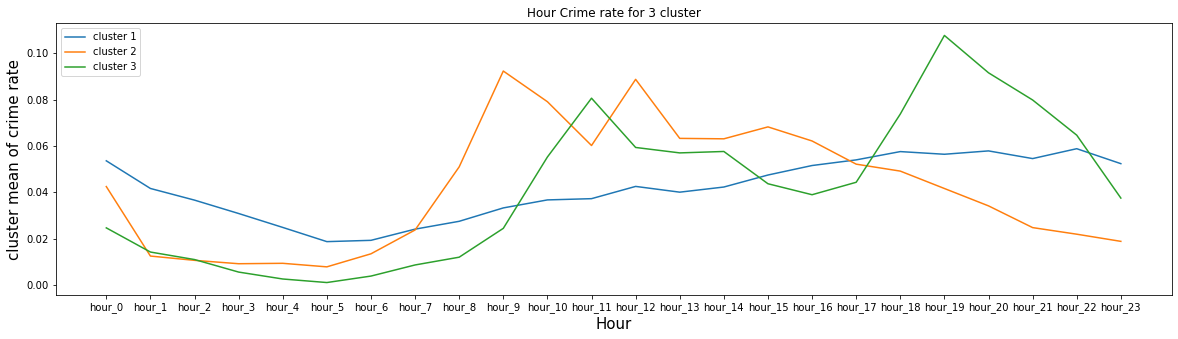

In [14]:
from matplotlib import pyplot as plt
ax = plt.figure(figsize = (20,5))
plt.plot(c_mean.loc[0], label = 'cluster 1')
plt.plot(c_mean.loc[1], label = 'cluster 2')
plt.plot(c_mean.loc[2], label = 'cluster 3')
plt.legend(loc = 'upper left')
plt.title('Hour Crime rate for 3 cluster')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('cluster mean of crime rate', fontsize=15)
plt.show()

In [15]:
data3['ktype'] = fit_kmeans.labels_
data_crimes_1 = data3.loc[data3['ktype']==0]
print(data_crimes_1['crime_type'])
data_crimes_2 = data3.loc[data3['ktype']==1]
print(data_crimes_2['crime_type'])
data_crimes_3 = data3.loc[data3['ktype']==2]
print(data_crimes_3['crime_type'])


0                                         ARSON: BY FIRE
1                    ASSAULT: AGG PO HANDS NO/MIN INJURY
2                           ASSAULT: AGGRAVATED: HANDGUN
3                 ASSAULT: AGGRAVATED: OTHER DANG WEAPON
4                     ASSAULT: AGGRAVATED: OTHER FIREARM
                             ...                        
113                               THEFT: PURSE-SNATCHING
115        WEAPONS VIOLATION: RECKLESS FIREARM DISCHARGE
116          WEAPONS VIOLATION: UNLAWFUL POSS OF HANDGUN
117              WEAPONS VIOLATION: UNLAWFUL USE HANDGUN
118    WEAPONS VIOLATION: UNLAWFUL USE OTHER DANG WEAPON
Name: crime_type, Length: 70, dtype: object
6                   ASSAULT: PRO EMP HANDS NO/MIN INJURY
19                  BATTERY: PRO EMP HANDS NO/MIN INJURY
24                              BURGLARY: UNLAWFUL ENTRY
36     DECEPTIVE PRACTICE: ATTEMPT - FINANCIAL IDENTI...
37                       DECEPTIVE PRACTICE: BOGUS CHECK
38                 DECEPTIVE PRACTICE: COUNT

In [16]:
days = data3.iloc[:,[2,3,4,5,6,7,8,110]]
c_day = days.groupby(['ktype']).mean()
c_day

,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat
ktype,,,,,,,
0,0.146857,0.140419,0.138529,0.135427,0.136949,0.149808,0.152011
1,0.108502,0.150429,0.152455,0.153047,0.153902,0.158629,0.123036
2,0.114714,0.141288,0.160484,0.148855,0.146087,0.156921,0.131651


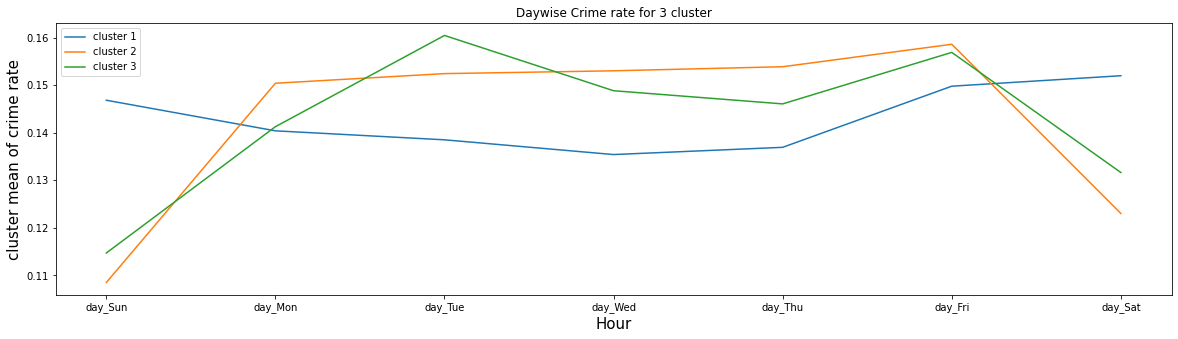

In [17]:
ax = plt.figure(figsize = (20,5))
plt.plot(c_day.loc[0], label = 'cluster 1')
plt.plot(c_day.loc[1], label = 'cluster 2')
plt.plot(c_day.loc[2], label = 'cluster 3')
plt.legend(loc = 'upper left')
plt.title('Daywise Crime rate for 3 cluster')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('cluster mean of crime rate', fontsize=15)
plt.show()

In [18]:
community = data3.iloc[:,range(33,111)]
c_community = community.groupby(['ktype']).mean()
c_community

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
ktype,,,,,,,,,,,,,,,,,,,,,
0,0.014063,0.012539,0.013563,0.007220,0.004095,0.020895,0.010175,0.027591,0.000680,0.003464,...,0.026472,0.028997,0.009295,0.029066,0.002842,0.011455,0.001561,0.007094,0.010014,0.007291
1,0.014446,0.014380,0.016437,0.010941,0.007502,0.024766,0.018054,0.053912,0.002169,0.007858,...,0.017873,0.020703,0.010150,0.023909,0.005234,0.011028,0.004348,0.009446,0.009696,0.012677
2,0.007933,0.005855,0.007573,0.002209,0.001145,0.006267,0.001626,0.014067,0.000393,0.001321,...,0.037812,0.027129,0.002288,0.032473,0.000902,0.009801,0.000580,0.007220,0.000915,0.001499


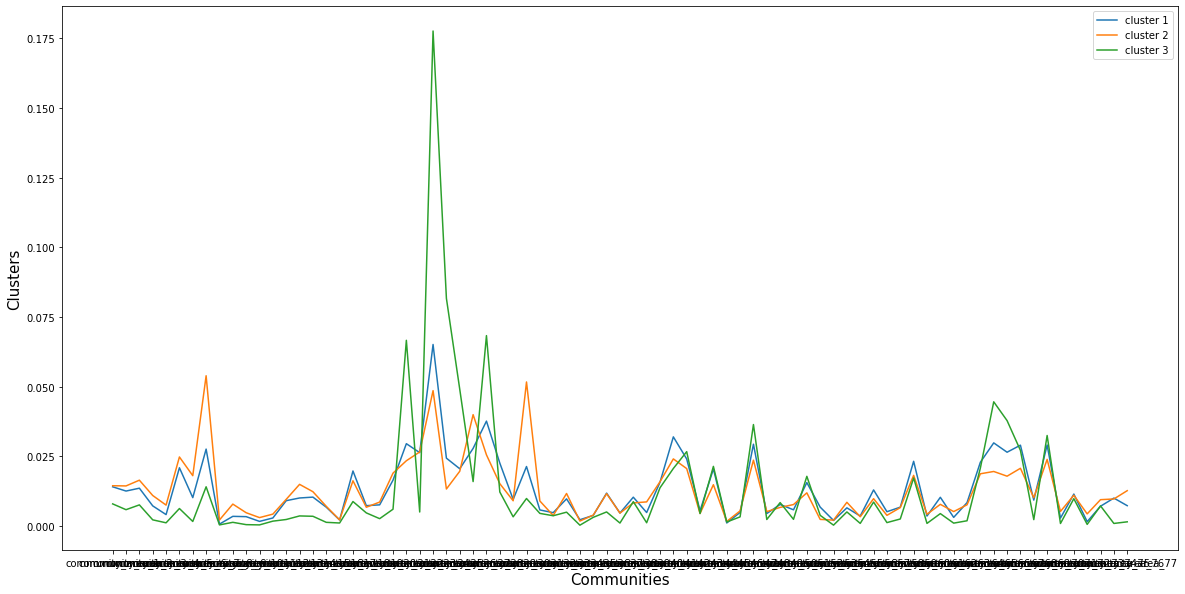

In [19]:
plt.figure(figsize=(20,10))
plt.plot(c_community.loc[0], label = 'cluster 1')
plt.plot(c_community.loc[1], label = 'cluster 2')
plt.plot(c_community.loc[2], label = 'cluster 3')

plt.legend(loc = 'upper right')
plt.xlabel('Communities',fontsize=15)
plt.ylabel('Clusters',fontsize=15)

plt.show()

In [20]:
df_c = c_community.transpose()
df_c

ktype,0,1,2
community_area_1,0.014063,0.014446,0.007933
community_area_2,0.012539,0.014380,0.005855
community_area_3,0.013563,0.016437,0.007573
community_area_4,0.007220,0.010941,0.002209
community_area_5,0.004095,0.007502,0.001145
...,...,...,...
community_area_73,0.011455,0.011028,0.009801
community_area_74,0.001561,0.004348,0.000580
community_area_75,0.007094,0.009446,0.007220
community_area_76,0.010014,0.009696,0.000915


In [21]:
df_c = df_c.rename(columns={0: 'k1', 1 :'k2', 2:'k3'}) 

In [22]:
df_k1 = df_c.nlargest(5, ['k1'])
df_k2 = df_c.nlargest(5,['k2'])
df_k3 = df_c.nlargest(5,['k3'])
print(df_k1)
print(df_k2)
print(df_k3)

ktype                    k1        k2        k3
community_area_25  0.065128  0.048565  0.177602
community_area_29  0.037632  0.025529  0.068311
community_area_43  0.031980  0.024071  0.020641
community_area_67  0.029819  0.019564  0.044557
community_area_23  0.029533  0.023414  0.066626
ktype                    k1        k2        k3
community_area_8   0.027591  0.053912  0.014067
community_area_32  0.021342  0.051680  0.009864
community_area_25  0.065128  0.048565  0.177602
community_area_28  0.027840  0.039949  0.015941
community_area_24  0.026321  0.026575  0.005023
ktype                    k1        k2        k3
community_area_25  0.065128  0.048565  0.177602
community_area_26  0.024340  0.013271  0.081675
community_area_29  0.037632  0.025529  0.068311
community_area_23  0.029533  0.023414  0.066626
community_area_27  0.020537  0.019647  0.049040


In [23]:
data_m = data4.loc[data4['Community Area Number'].isin([8,23,24,25,26,27,28,29,32,43,67])]
data_m

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
7,8,Near North Side,1175512.220,1906089.147,1.9,12.9,7.0,2.5,22.6,88669,17.077160,9847
22,23,Humboldt park,1151216.159,1906926.141,14.8,33.9,17.3,35.4,38.0,13781,15.839488,7522
23,24,West Town,1163041.478,1907678.393,2.3,14.7,6.6,12.9,21.7,43198,8.734616,7754
24,25,Austin,1140839.462,1903174.321,6.3,28.6,22.6,24.4,37.9,15957,14.188517,15719
25,26,West Garfield Park,1148754.852,1898785.758,9.4,41.7,25.8,24.5,43.6,10934,27.504936,5340
26,27,East Garfield Park,1155086.641,1898653.301,8.2,42.4,19.6,21.3,43.2,12961,19.899589,4727
27,28,Near West Side,1167030.371,1898359.955,3.8,20.6,10.7,9.6,22.2,44689,11.790159,8891
28,29,North Lawndale,1152306.328,1892568.863,7.4,43.1,21.2,27.6,42.7,12034,21.888178,8073
31,32,Loop,1176373.765,1899831.267,1.5,14.7,5.7,3.1,13.5,65526,24.629080,8471
42,43,South Shore,1191640.433,1856742.384,2.8,31.1,20.0,14.0,35.7,19398,18.541882,7673


We can observe that Austin is the most notorius neighborhood for crime in chicago as the number of crimes, poverty and vacant houses in th area are on the higher side. Austin ranks high in all the clusters of crime rate. Rest of the neighborhoods like Garfield Park(both west and east), West Englewood and North Lawndale rank high on the below poverty line population, so we can deduce the cause of high crime in these areas. We can also observe the neighborhoods in the higher ranks of cluster 3, have greater number of 16+ age unemployed population and 25+ population without high school diploma.

In [24]:
for i in range(3):
    print("Cluster {}".format(i))
    print(data3[data3['ktype']==i].Category.value_counts())
    print("\n")

Cluster 0
P2     35
P1V    24
P1P    11
Name: Category, dtype: int64


Cluster 1
P2     23
P1P     4
Name: Category, dtype: int64


Cluster 2
P2    22
Name: Category, dtype: int64




In [25]:
c_weekend = data3.loc[:,"day_Sun":"day_Sat"]


In [26]:
## K means 
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
cluster_r = range(2,10)

for n_clusters in cluster_r:
    model = KMeans(random_state=999, n_clusters= n_clusters)
    preds = model.fit_predict(c_weekend)
    silhouette_avg = silhouette_score(c_weekend, preds)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))


For n_clusters = 2, the average silhouette_score is : 0.23496703980224024
For n_clusters = 3, the average silhouette_score is : 0.21738630734570294
For n_clusters = 4, the average silhouette_score is : 0.23234767220059055
For n_clusters = 5, the average silhouette_score is : 0.23474667108179323
For n_clusters = 6, the average silhouette_score is : 0.163803671915844
For n_clusters = 7, the average silhouette_score is : 0.16513480882740134
For n_clusters = 8, the average silhouette_score is : 0.1706750526759911
For n_clusters = 9, the average silhouette_score is : 0.17279947733487447


In [27]:
kmeans_cl = KMeans(n_clusters = 5, random_state= 999)
fit_kmeans = kmeans_cl.fit(c_weekend)
kmeans_data = c_weekend.copy()
kmeans_data['ktype'] = fit_kmeans.labels_
print (kmeans_data['ktype'].value_counts())

2    55
0    44
3    14
1     4
4     2
Name: ktype, dtype: int64


In [28]:
## Gaussian Mixture
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
df_Gaussian=c_weekend.copy()
for n_clusters in cluster_r:
    model = GaussianMixture(random_state=999, n_components=n_clusters)
    preds = model.fit_predict(df_Gaussian)
    silhouette_avg = silhouette_score(df_Gaussian, preds)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.25672726757004677
For n_clusters = 3, the average silhouette_score is : 0.22826072559007612
For n_clusters = 4, the average silhouette_score is : 0.24345869700314285
For n_clusters = 5, the average silhouette_score is : 0.07585061723250218
For n_clusters = 6, the average silhouette_score is : 0.11075901696401529
For n_clusters = 7, the average silhouette_score is : 0.08303544885421206
For n_clusters = 8, the average silhouette_score is : 0.1482899536588825
For n_clusters = 9, the average silhouette_score is : 0.1508278665495685


In [29]:
gmm = GaussianMixture(n_components=2,random_state=999)
res = gmm.fit_predict(df_Gaussian)

df_Gaussian['label']=res
df_Gaussian['label'].value_counts()

0    89
1    30
Name: label, dtype: int64

In [30]:
## Bottom up hierarchical clustering  - single link 
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

df_hc=c_weekend.copy()

for n_clusters in cluster_r:
    model = linkage(df_hc, 'single')
    preds = fcluster(model, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(df_hc, preds)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.6377648080667613
For n_clusters = 3, the average silhouette_score is : 0.5568477382969328
For n_clusters = 4, the average silhouette_score is : 0.40557775075981545
For n_clusters = 5, the average silhouette_score is : 0.3877038188748669
For n_clusters = 6, the average silhouette_score is : 0.39007619510221897
For n_clusters = 7, the average silhouette_score is : 0.34621844820394365
For n_clusters = 8, the average silhouette_score is : 0.328998157643559
For n_clusters = 9, the average silhouette_score is : 0.3254219274892415


In [31]:
model = linkage(df_hc, 'single')
preds = fcluster(model, 2, criterion='maxclust')
df_hc['ktype']=preds

df_hc['ktype'].value_counts()

1    118
2      1
Name: ktype, dtype: int64

In [32]:
## Bottom-up hierarchical clustering - complete link
df_hc2=c_weekend.copy()
for n_clusters in cluster_r:
    model = linkage(df_hc2, 'complete')
    preds = fcluster(model, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(df_hc2, preds)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))


For n_clusters = 2, the average silhouette_score is : 0.6100646113547024
For n_clusters = 3, the average silhouette_score is : 0.17268718146566103
For n_clusters = 4, the average silhouette_score is : 0.192151693747686
For n_clusters = 5, the average silhouette_score is : 0.15025207822499756
For n_clusters = 6, the average silhouette_score is : 0.1522968157222807
For n_clusters = 7, the average silhouette_score is : 0.14926267616109432
For n_clusters = 8, the average silhouette_score is : 0.10130440123428013
For n_clusters = 9, the average silhouette_score is : 0.10066503899164748


In [33]:
model = linkage(df_hc2, 'complete')
preds = fcluster(model, 2, criterion='maxclust')
df_hc2['ktype']=preds
df_hc2['ktype'].value_counts()

2    117
1      2
Name: ktype, dtype: int64

For most of the methods n=2 cluster reports the highest score except for k means method, where it has the second highest score.